<a href="https://colab.research.google.com/github/uervitonsantos/Algoritmo-PSO-para-otimiza-o-de-custo-de-manuten-o-preventiva/blob/main/Algoritmo_PSO_para_otimiza_o_de_custo_de_manuten_o_preventiva_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [289]:
import numpy as np
import random
from scipy.optimize import minimize
from scipy.stats import poisson
import math
import matplotlib.pyplot as plt

In [290]:
# Função de verossimilhança para distribuição de Poisson
def poisson_likelihood(lam, data):
    log_likelihood = np.sum(poisson.logpmf(data, lam))
    return log_likelihood

In [291]:
# Função de verossimilhança para distribuição de lei de potência
def powerlaw_likelihood(params, data):
    alpha, xmin = params
    n = len(data)
    lam = (alpha - 1) / xmin * (data ** (1 - alpha))
    log_likelihood = np.sum(np.log(lam))
    return -log_likelihood

In [292]:
# Função de verossimilhança combinada para distribuição de lei de potência e Poisson
def combined_likelihood(params, data):
    alpha, xmin, lam = params
    return powerlaw_likelihood([alpha, xmin], data) + poisson_likelihood(lam, data)

In [293]:
# Dados observados de eventos raros
data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [294]:
# Estimando os parâmetros da distribuição de lei de potência
initial_guess = [1, 10]  # Chute inicial para os parâmetros alpha e xmin
result_powerlaw = minimize(powerlaw_likelihood, initial_guess, args=(data,), method='BFGS')
alpha_hat, xmin_hat = result_powerlaw.x

<ipython-input-291-b614e7906980>:6: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(lam))


In [295]:
# Estimando o parâmetro lambda da distribuição de Poisson usando a função de verossimilhança combinada
def combined_likelihood_poisson(params, data):
    alpha, xmin, lam = params
    return combined_likelihood([alpha, xmin, lam], data)

In [296]:
# Função de penalidade para restrição de limites para lambda
def lambda_penalty(params, data, lambda_penalty_weight=1e6):
    alpha, xmin, lam = params
    lam_diff = lam - round(lam)  # Diferença entre lam e seu valor arredondado
    penalty = lambda_penalty_weight * lam_diff**2  # Função de penalidade quadrática
    return penalty

In [297]:
# Função para minimizar a verossimilhança combinada com lambda como parâmetro inteiro
def minimize_combined_likelihood_poisson(params, data):
    result_combined = minimize(
        fun=lambda params: combined_likelihood_poisson(params, data) + lambda_penalty(params, data),
        x0=[alpha_hat, xmin_hat, np.mean(data)],  # Chute inicial para os parâmetros alpha, xmin e lambda
        method='BFGS'
    )
    alpha, xmin, lam = result_combined.x
    lam = round(lam)  # Arredonda o valor de lambda para o inteiro mais próximo
    return alpha, xmin, lam

In [298]:
# Estimando o parâmetro lambda como o valor inteiro que minimiza a função de verossimilhança combinada
initial_guess_combined = np.array([alpha_hat, xmin_hat, lam_hat])
result_combined = minimize(combined_likelihood, initial_guess_combined, args=(data,), method='BFGS')

alpha_hat, xmin_hat, lam_hat = result_combined.x

<ipython-input-291-b614e7906980>:6: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(lam))


In [299]:
print("Parâmetros estimados:")
print("Alpha (coeficiente de inclinação da lei de potência):", alpha_hat)
print("Xmin (valor mínimo do evento):", xmin_hat)
print("Lambda (taxa média de ocorrência da distribuição de Poisson):", round(lam_hat))

Parâmetros estimados:
Alpha (coeficiente de inclinação da lei de potência): 1.0
Xmin (valor mínimo do evento): 10.0
Lambda (taxa média de ocorrência da distribuição de Poisson): -1034


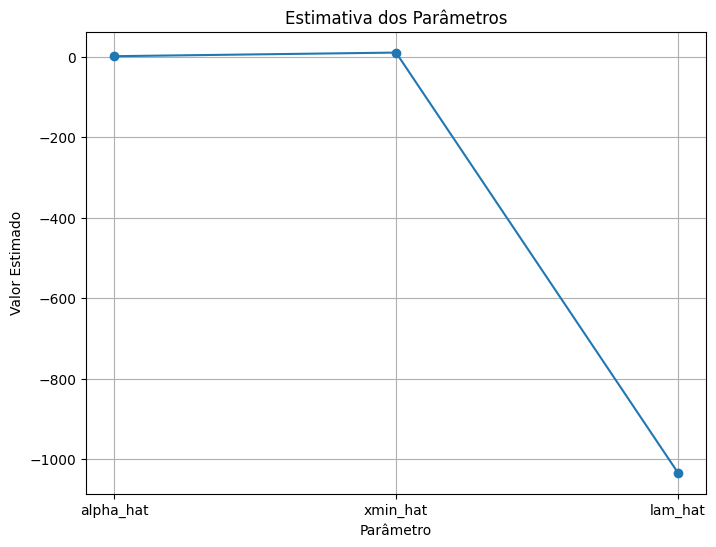

In [300]:
# Valores estimados dos parâmetros
parametros = ['alpha_hat', 'xmin_hat', 'lam_hat']
valores = [alpha_hat, xmin_hat, lam_hat]

# Plotando os resultados
plt.figure(figsize=(8, 6))
plt.plot(parametros, valores, marker='o')
plt.xlabel('Parâmetro')
plt.ylabel('Valor Estimado')
plt.title('Estimativa dos Parâmetros')
plt.grid(True)
plt.show()

In [301]:
# A função custo_manutencao representa a função de custo que você deseja minimizar. 
# Ela recebe como entrada um vetor x que contém as variáveis de decisão do problema.


"""
    A função de custo custo_manutencao foi definida com base no artigo (An Integrated 
    Flow Shop Scheduling Problem of Preventive Maintenance and Degradation With an 
    Improved NSGA-II Algorithm, 2023), que trata de um problema de programação de manutenção 
    preventiva e degradação em uma fábrica de fluxo integrado. A função consiste em duas partes:

    1 - A primeira parte (system_degradation) representa o custo de degradação do equipamento. A 
    variável (system_degradation) é calculada como uma função da diferença entre o tempo de uso atual do 
    equipamento e seu tempo de vida útil, com um termo de ajuste exponencial.

    2 - A segunda parte (c1-c5) representa o custo de manutenção preventiva. Cada 
    variável c é calculada como uma função do tempo de uso do equipamento, com um 
    termo de ajuste exponencial.

    O custo total é calculado somando-se as duas partes para todas as cinco variáveis. 
    O objetivo do problema é encontrar a combinação de valores para as variáveis x que 
    minimize a função de custo custo_manutencao.
"""

def custo_manutencao(x):

    list_of_severity = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    cost_downtime  = 4000 # custo por dia de inatividade do sistema
    maintenance_severity = random.choice(list_of_severity) # o gral de severidade aplicado na manutenção pode varia em uma escala de [10...100] %
    #cost_maintenance  = ((cost_downtime*maintenance_severity)/100) # custo médio das manutenções
    cost_maintenance = np.maximum(0, (1 - np.exp(-x[0] / 20)) * x[0] * np.exp(-x[0] / 100)) # custo médio das manutenções
    system_degradation = np.maximum(0, 1 - x[0] / 10) * np.exp(2 * np.power((x[0] - 10) / 10, 3))
 
    custo = (system_degradation + cost_maintenance)

    return custo


In [302]:
# Define o tamanho da população e o número de dimensões
tam_populacao = 10
num_dimensoes = 5

# Define os limites inferior e superior para as dimensões
limites_inferiores = np.zeros(num_dimensoes)
limites_superiores = np.ones(num_dimensoes) * 10

In [303]:
# Define a função de atualização da posição do enxame
def atualiza_posicao_enxame(x, v, p_best, g_best, w, c1, c2):
    r1 = np.random.rand(num_dimensoes)
    r2 = np.random.rand(num_dimensoes)
    v = w*v + c1*r1*(p_best - x) + c2*r2*(g_best - x)
    x = x + v
    return x, v

In [304]:
# Define os parâmetros do PSO
num_iteracoes = 100
w = 0.5
c1 = 1.5
c2 = 1.5

In [305]:
# Inicializa a população e a velocidade do enxame
populacao = np.random.uniform(limites_inferiores, limites_superiores, (tam_populacao, num_dimensoes))
velocidade = np.zeros((tam_populacao, num_dimensoes))

In [306]:
# Inicializa as melhores posições da população e a melhor posição global
p_best = populacao.copy()
custo_p_best = np.zeros(tam_populacao)
for i in range(tam_populacao):
    custo_p_best[i] = custo_manutencao(populacao[i])
g_best_index = np.argmin(custo_p_best)
g_best = p_best[g_best_index].copy()

# Lista para armazenar o custo de cada iteração
custo_minimo_iteracoes = []

# Executa o PSO
for i in range(num_iteracoes):
    for j in range(tam_populacao):
        custo_j = custo_manutencao(populacao[j])
        if custo_j < custo_p_best[j]:
            p_best[j] = populacao[j].copy()
            custo_p_best[j] = custo_j
        if custo_j < custo_manutencao(g_best):
            g_best = populacao[j].copy()
    populacao, velocidade = atualiza_posicao_enxame(populacao, velocidade, p_best, g_best, w, c1, c2)

    # Adiciona o custo da iteração à lista
    custo_minimo_iteracao = custo_manutencao(g_best)
    custo_minimo_iteracoes.append(custo_minimo_iteracao)

In [307]:
# Exibe a solução encontrada
print("Melhor posição encontrada:", g_best)
print("Custo mínimo encontrado:", custo_manutencao(g_best))

Melhor posição encontrada: [-0.55901337  8.78614574  4.65513775  2.56468592  5.43995419]
Custo mínimo encontrado: 0.11618160727263648


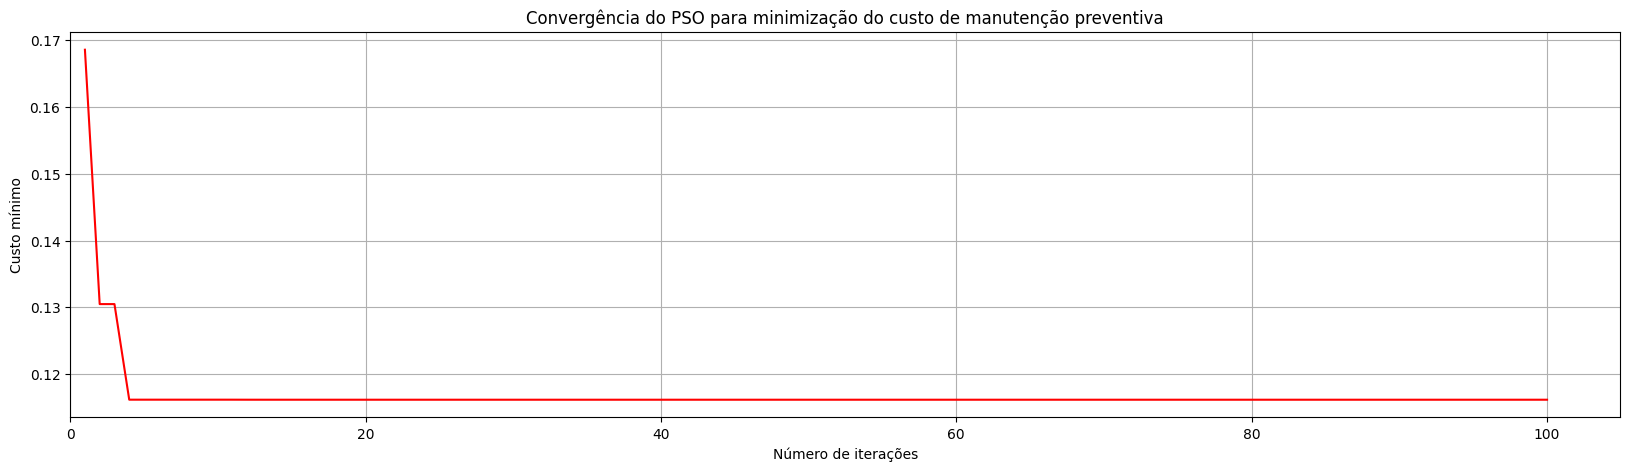

In [308]:
# Plota o gráfico do custo em função do número de iterações
fig_verify = plt.figure(figsize=(20, 5))
plt.plot(range(1, num_iteracoes+1), custo_minimo_iteracoes, color="red")
plt.xlabel('Número de iterações')
plt.ylabel('Custo mínimo')
plt.title('Convergência do PSO para minimização do custo de manutenção preventiva')
plt.xlim(0)
plt.grid(True)
plt.show()